This was modified from /SNS/ARCS/IPTS-21387/shared/Arnab_Vanadium/LoadPowderFilesV2p3.py .

In [1]:
#Program to load Vanadium or empty Can powder files and perform a constant-Q cut along the middle Q to look at energy resolution and intensity.
import matplotlib.pyplot as plt
from mantid import plots
from mantid.simpleapi import Load, ConvertToMD, BinMD, ConvertUnits, Rebin
from matplotlib.colors import LogNorm
import numpy as np
import mantid.simpleapi as msa
from mantid import mtd

In [3]:
# RunNumbers=range(107476,107648)+range(108331,108457) # FC1
# quick test: RunNumbers=range(107476,107480)
runno = 107623
RunNumbers=range(runno,runno+1)

print(RunNumbers)
IPTS=21387
datadir="/SNS/ARCS/IPTS-"+str(IPTS)+"/shared/autoreduce/"
overallArray=[]

range(107623, 107624)


107623


/SNS/software/miniconda2/envs/py3/lib/python3.6/site-packages/mantid/plots/helperfunctions.py:154: RuntimeWarning: invalid value encountered in true_divide
  data /= nev
/SNS/software/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Run= 107623 , Energy= 100.0 meV, Chopper= 1 ChopperPosition= 0.6710330000000001 , Fit= OK


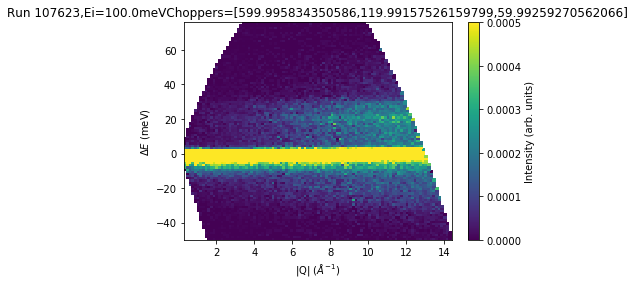

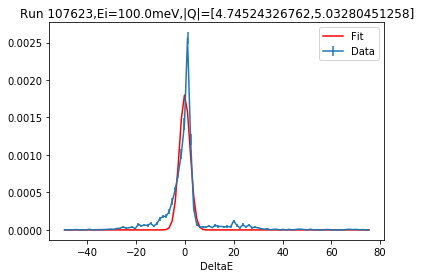

In [4]:
PlotTag=1

for RunNumber in RunNumbers:
    print (RunNumber)
    try:
        w=msa.CreateSingleValuedWorkspace()
        #LoadNexusLogs(w,"/SNS/ARCS/IPTS-"+str(IPTS)+"/data/ARCS_"+str(RunNumber)+'_event.nxs')
        msa.LoadNexusLogs(w,"/SNS/ARCS/IPTS-"+str(IPTS)+"/nexus/ARCS_"+str(RunNumber)+'.nxs.h5')
        RunParams=w.getRun()
        Energy=RunParams["BL18:Chop:Skf0:EnergyUserReq"].getStatistics().mean
        #print Energy
        Chopperpos=RunParams["chtrans"].getStatistics().mean
        #print Chopperpos
        Chopper1=RunParams["Speed1"].getStatistics().mean
        Chopper2=RunParams["Speed2"].getStatistics().mean
        Chopper3=RunParams["Speed3"].getStatistics().mean
        if Chopperpos>400: 
            Chopper=2 
        elif Chopperpos<1: 
            Chopper=1 
        else: 
            Chopper=0

        
        # generate a nice 2D multi-dimensional workspace
        data = msa.LoadNXSPE(datadir+'ARCS_'+str(RunNumber)+'_autoreduced.nxspe')
        values=msa.ConvertToMDMinMaxLocal('data',QDimensions='|Q|', dEAnalysisMode='Direct')
        minQ,minE=values.MinValues
        maxQ,maxE=values.MaxValues
        
        md = msa.ConvertToMD(InputWorkspace=data, QDimensions='|Q|', dEAnalysisMode='Direct')
        sqw = msa.BinMD(InputWorkspace=md,
                    AlignedDim0='|Q|,'+str(minQ)+','+str(maxQ)+',100',
                    AlignedDim1='DeltaE,'+ str(minE) +',' +str(maxE*0.8) +',100')

        #2D plot
        if PlotTag==1:
            fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
            c = ax.pcolormesh(sqw, vmin=0., vmax=0.5e-3)
            cbar=fig.colorbar(c)
            cbar.set_label('Intensity (arb. units)') #add text to colorbar
            ax.set_title('Run '+str(RunNumber)+',Ei='+str(Energy)+'meVChoppers=['+str(Chopper1)+','+str(Chopper2)+','+str(Chopper3)+']')
            fig.show()


        # generate a 1D multi-dimensional workspace


        sqw_line= msa.BinMD(InputWorkspace=md,
                    AlignedDim0='|Q|,' +str((minQ+maxQ)/3-0.01*maxQ) +','+ str((minQ+maxQ)/3+0.01*maxQ) +',1',
                    AlignedDim1='DeltaE,'+ str(minE) +',' +str(maxE*0.8) +',100')

        sqw_line_Hist=msa.ConvertMDHistoToMatrixWorkspace('sqw_line', Normalization='NumEventsNormalization')
        result=msa.Fit(Function='name=Gaussian,Height=1,PeakCentre=-'+str(0.01*Energy)+',Sigma='+str(0.1*Energy), InputWorkspace='sqw_line_Hist', Output='sqw_line_Hist', OutputCompositeMembers=True)

        # plots 1D multi-dimensional workspace
        if PlotTag==1:
            fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
            c = ax.errorbar(sqw_line_Hist,label='Data')
            ax.plot(result.OutputWorkspace,'r-',wkspIndex=1, label='Fit')
            ax.legend()
            ax.set_title('Run '+str(RunNumber)+',Ei='+str(Energy)+'meV,|Q|=[' +str((minQ+maxQ)/3-0.01*maxQ) +','+ str((minQ+maxQ)/3+0.01*maxQ) +']' )
            fig.show()

        handle=mtd['sqw_line_Hist_Parameters']
        RunParams2=data.getRun()
        Ei=RunParams2["Ei"].value
        height_row = handle.row(0); center_row = handle.row(1); sigma_row = handle.row(2)
        Height=height_row['Value']
        Center=center_row['Value']
        Sigma=sigma_row['Value']
        dHeight=height_row['Error']
        dCenter=center_row['Error']
        dSigma=sigma_row['Error']
        Q=(minQ+maxQ)/3
        array=[0,RunNumber, Energy, Ei, Chopper, round(Chopper1), round(Chopper2), round(Chopper3), Height, dHeight, Center, dCenter, Sigma, dSigma, Q]
        if dHeight*3>Height:
            String1=', Fit= Error: Fit errors too high'
        elif abs(Center)>abs(dCenter)*3:
            String1=', Fit= Error: Bragg peak not at E=0'
        else:
            String1=', Fit= OK'
        print("Run=",RunNumber,", Energy=",Energy,"meV, Chopper=",Chopper,"ChopperPosition=",Chopperpos,String1)
        #print array
        overallArray.append(array)
        
    except:
        raise
        print(RunNumber,": Errors, either file not in directory or some syntax, or fitting / plot errors")


# print overallArray
toPrint=np.c_[overallArray]

In [27]:
# np.savetxt("/SNS/ARCS/IPTS-"+str(IPTS)+"/shared/Arnab_Vanadium/File_FC1_allRuns1.dat",toPrint,header='RunNumber Energy Ei Chopper Chopper1 Chopper2 Chopper3 Height dHeight Center dCenter Sigma dSigma Q')